# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn

# merging the 2 Excel worksheets
df_merge = pd.merge(df_transactions, df_offers, how='outer')

# pretended dataframe
df = pd.pivot_table(df_merge, values='n', index='customer_name', columns='offer_id').fillna(0)
 
# new dataframe
df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [5]:
# your turn


**What values of  𝑆𝑆  do you believe represent better clusterings? Why?**

Lower values the better, as there is a shorter distance between the centroid and all the points belonging to the cluster. 

**Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)**

In [6]:
# x_cols
x_cols = np.matrix(df)
x_cols

matrix([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 1.]])

**Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.**

In [7]:
from sklearn.cluster import KMeans

model = KMeans()

# fit to x_cols
model.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

**Construct a plot showing  𝑆𝑆  for each  𝐾  and pick  𝐾  using this plot. For simplicity, test  2≤𝐾≤10 .**

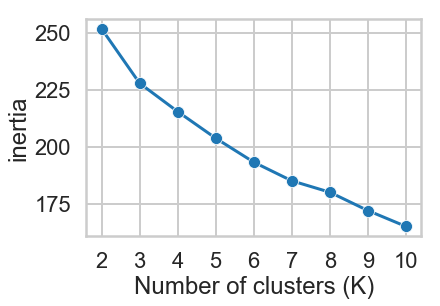

In [8]:
# the SS in sklearn.cluster.KMeans is given by the attribute 'inertia_'

# constructing a lineplot to determine the best K (number_of_clusters)
number_of_clusters = np.arange(2, 11)
inertia = []

# iterate over the possible K, with a random generator seed of 10 for reproducibility.
for i in number_of_clusters:
    model = KMeans(n_clusters=i, random_state=10)
    model.fit(x_cols)
    inertia.append(model.inertia_)

# plot
sns.lineplot(number_of_clusters, inertia, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("inertia")
plt.xticks(number_of_clusters)
plt.show()

There is not a clear "elbow" when plotting the SS against the number of clusters in the model, but I will choose K=5.

**Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 .**

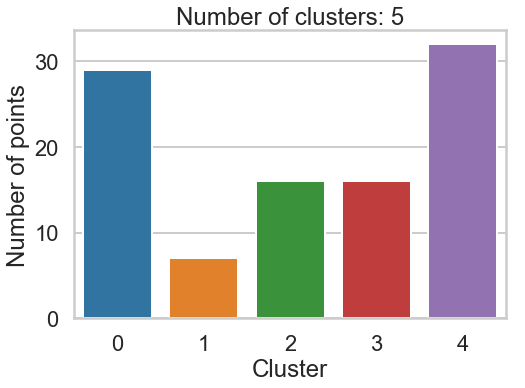

In [9]:
# chosen K
K = 5

# K-Means under the chosen K
model = KMeans(n_clusters=K, random_state=10)

# fit the model to the data, x_cols
model.fit_predict(x_cols)

# labels of the model (in sklearn, it starts in 0)
labels = list(model.labels_)

# number of points in each cluster
n_points = [labels.count(i) for i in set(labels)]

# barplot
sns.barplot(x=np.arange(K), y=n_points)
plt.title("Number of clusters: {}".format(K))
plt.xlabel("Cluster")
plt.ylabel("Number of points")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

**What challenges did you experience using the Elbow method to pick  𝐾 ?**

With the Elbow method the choice of K is not very obvious, since there is not a clear formation of an "elbow" where we start to see a minimal improvement as K increases. Since it is instead a somewhat linear representation, the choice of K becomes highly dependent on complementary analysis, as, for example, the observation of other relationships between the customers that might suggest a proper number. In this case, the Elbow method is not as helpful as it usually is.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [10]:
# Your turn.


For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


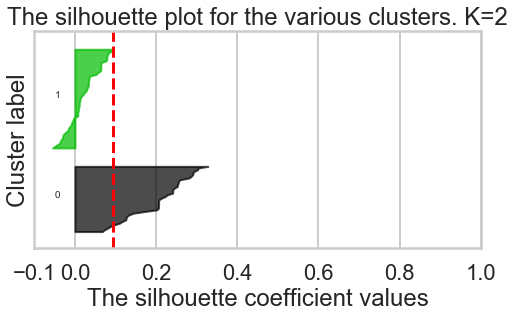

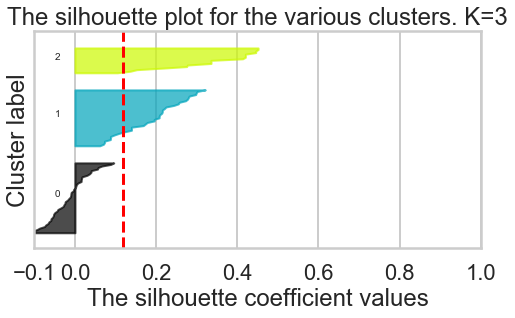

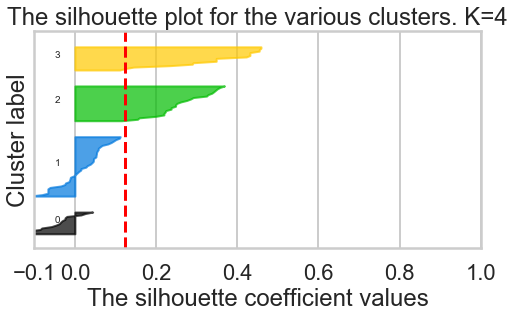

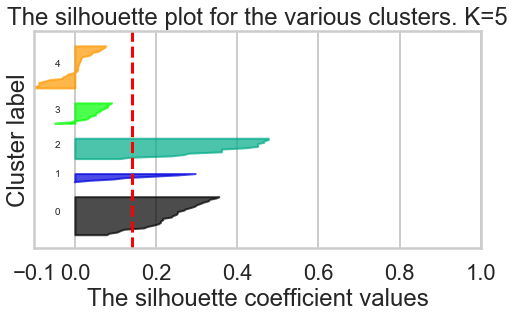

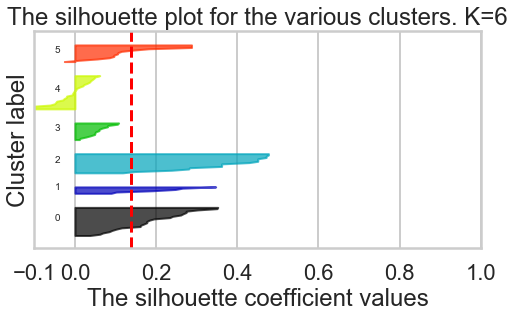

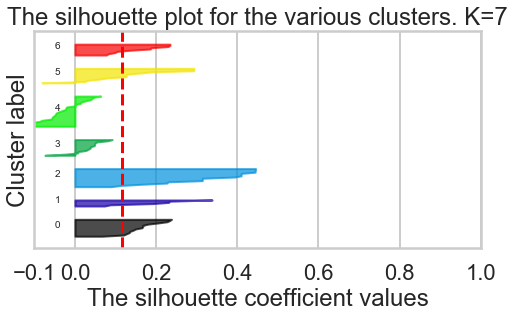

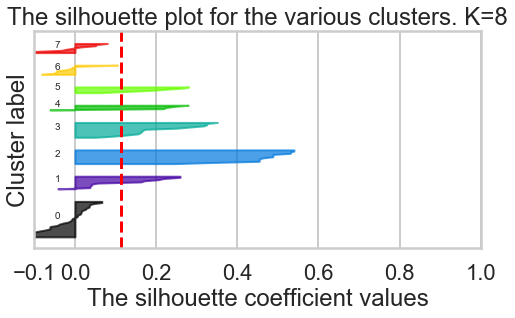

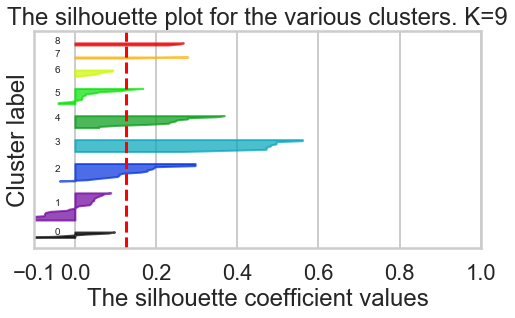

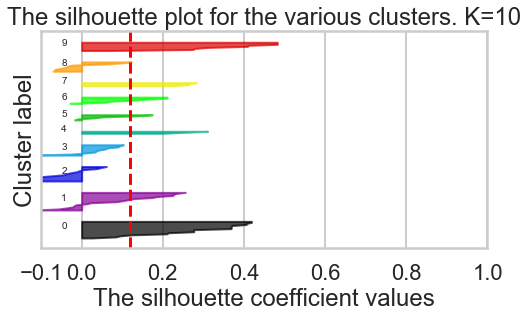

In [11]:
from sklearn.metrics import silhouette_score ,silhouette_samples
import matplotlib.cm as cm

# range of the number of clusters previously defined
number_of_clusters

# iterate
for n_clusters in number_of_clusters:
    # Create a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters. K={}".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


The plots suggest that K=5 is a fine choice. It has the highest average silhouette score. However, there is still some ambiguity. K=6 would have been a good choice too, as the cluster size is more similar among the data (represented by the thickness of the silhouette plot). I chose K=5 when dealing with the Elbow method, so it does not change, not forgetting that it was also ambiguous as it was explained, as it could have been equal to 6, 7, or even 4. With the Silhouette method, K=5 or 6, although far from perfect, seems the best choice. I will stick with 5.

Again, complementary analysis would be welcome.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [12]:
#your turn
x_cols.shape

(100, 32)

**Exercise: Use PCA to plot your clusters**

**reduce the dimensionality of your clustering data to 2 components**

In [13]:
from sklearn.decomposition import PCA

# PCA model with 2 components
pca = PCA(n_components=2)

# fit
pca.fit(x_cols)

# features
pca_features = pca.transform(x_cols)

pca_features.shape

(100, 2)

**Create a data frame**

In [14]:
# chosen K
K = 5

# model: KMeans
model = KMeans(n_clusters=K, random_state=10)

# fit_predict
cluster_id = model.fit_predict(x_cols)

# PCA components
x = pca_features[:, 0]
y = pca_features[:, 1]

# new dataframe
new_df = pd.DataFrame({'customer_name': df.index, 'cluster_id': cluster_id, 'x': x, 'y': y})

new_df.head()

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,4,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


**scatterplot**

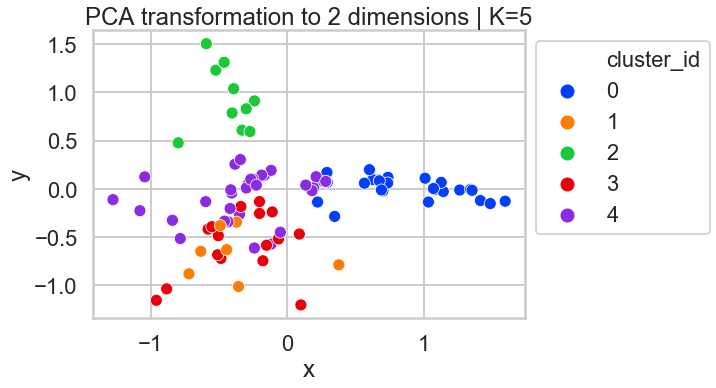

In [15]:
# scatterplot
palette = sns.color_palette("bright", K)
sns.scatterplot(x='x', y='y', data=new_df, hue='cluster_id', palette=palette)

# formatting
plt.title("PCA transformation to 2 dimensions | K={}".format(K))
plt.legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

**How do the clusters look?**

There is some differentiation, but in the center there is some overlapping. The green and the blue cluster differentiate from the others, while the others not. (with K=5)

**Based on what you see, what seems to be the best value for  𝐾 ? Moreover, which method of choosing  𝐾  seems to have produced the optimal result visually?**

Maybe K=3 would be the best. I would join the red, violet and orange clusters (3, 4 and 1). Both methods pointed initially to K=5, and both were ambiguous, but probably the Elbow method pointed (me) more to this renewed direction of choosing K=3.

**Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?**

*I will now assume the new **K=3**, so I will first redo the previous analysis (just changing K):*

In [16]:
# chosen K
K = 3

# model: KMeans
model = KMeans(n_clusters=K, random_state=10)

# fit_predict
cluster_id = model.fit_predict(x_cols)

# PCA components
x = pca_features[:, 0]
y = pca_features[:, 1]

# new dataframe
new_df = pd.DataFrame({'customer_name': df.index, 'cluster_id': cluster_id, 'x': x, 'y': y})

new_df.head()

,customer_name,cluster_id,x,y
0,Adams,1,1.007580,0.108215
1,Allen,0,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


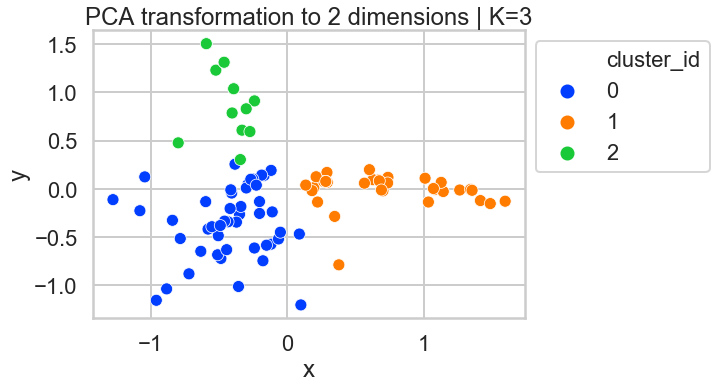

In [17]:
# scatterplot
palette = sns.color_palette("bright", K)
sns.scatterplot(x='x', y='y', data=new_df, hue='cluster_id', palette=palette)

# formatting
plt.title("PCA transformation to 2 dimensions | K={}".format(K))
plt.legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

New number of points in each cluster:

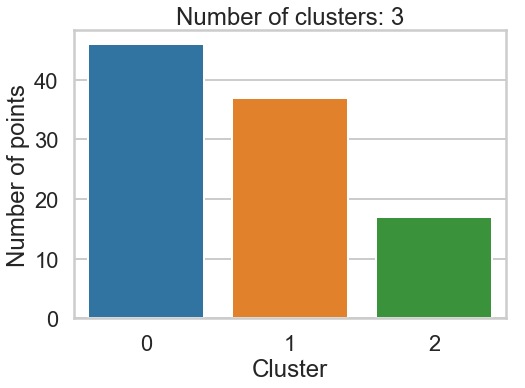

In [18]:
# chosen K
K = 3

# K-Means under the chosen K
model = KMeans(n_clusters=K, random_state=10)

# fit the model to the data, x_cols
model.fit_predict(x_cols)

# labels of the model (in sklearn, it starts in 0)
labels = list(model.labels_)

# number of points in each cluster
n_points = [labels.count(i) for i in set(labels)]

# barplot
sns.barplot(x=np.arange(K), y=n_points)
plt.title("Number of clusters: {}".format(K))
plt.xlabel("Cluster")
plt.ylabel("Number of points")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()


In [19]:
# merging the raw data with the given clusters
raw_clust = pd.merge(new_df, df_merge, how='outer').drop(['x', 'y', 'n'], axis=1)

raw_clust.head()

,customer_name,cluster_id,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,Adams,1,18,July,Espumante,6,50,Oregon,False
1,Adams,1,29,November,Pinot Grigio,6,87,France,False
2,Adams,1,30,December,Malbec,6,54,France,False
3,Allen,0,9,April,Chardonnay,144,57,Chile,False
4,Allen,0,27,October,Champagne,72,88,New Zealand,False


*Analysis of the variables*

campaign

In [20]:
raw_clust['campaign'].unique()

array(['July', 'November', 'December', 'April', 'October', 'September',
       'March', 'August', 'January', 'May', 'February', 'June'],
      dtype=object)

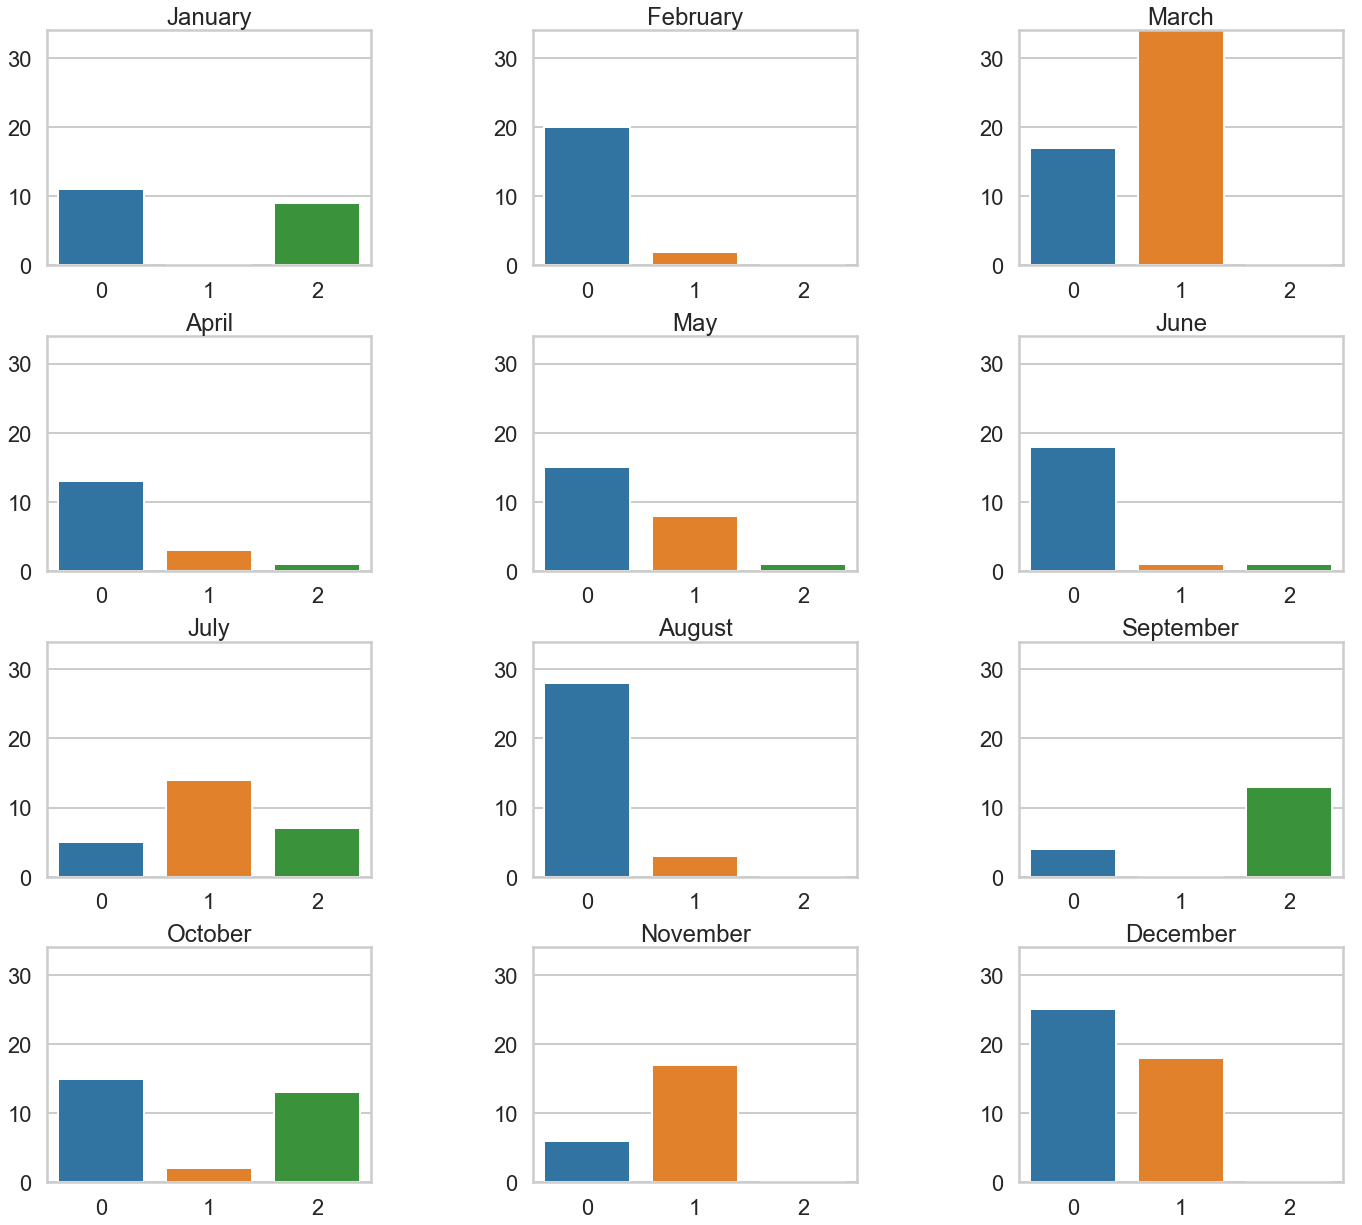

In [21]:
# Variable
variable = 'campaign'

# labels
clusters = np.arange(K)

# options
import calendar
options = list(calendar.month_name)[1:]

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(4, 3, i+1)
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title(options[i])
    
plt.subplots_adjust(left=0, bottom=-3, right=3, top=1, wspace=0.5, hspace=0.3)
plt.show()

varietal

In [22]:
raw_clust['varietal'].unique()

array(['Espumante', 'Pinot Grigio', 'Malbec', 'Chardonnay', 'Champagne',
       'Pinot Noir', 'Prosecco', 'Cabernet Sauvignon', 'Merlot'],
      dtype=object)

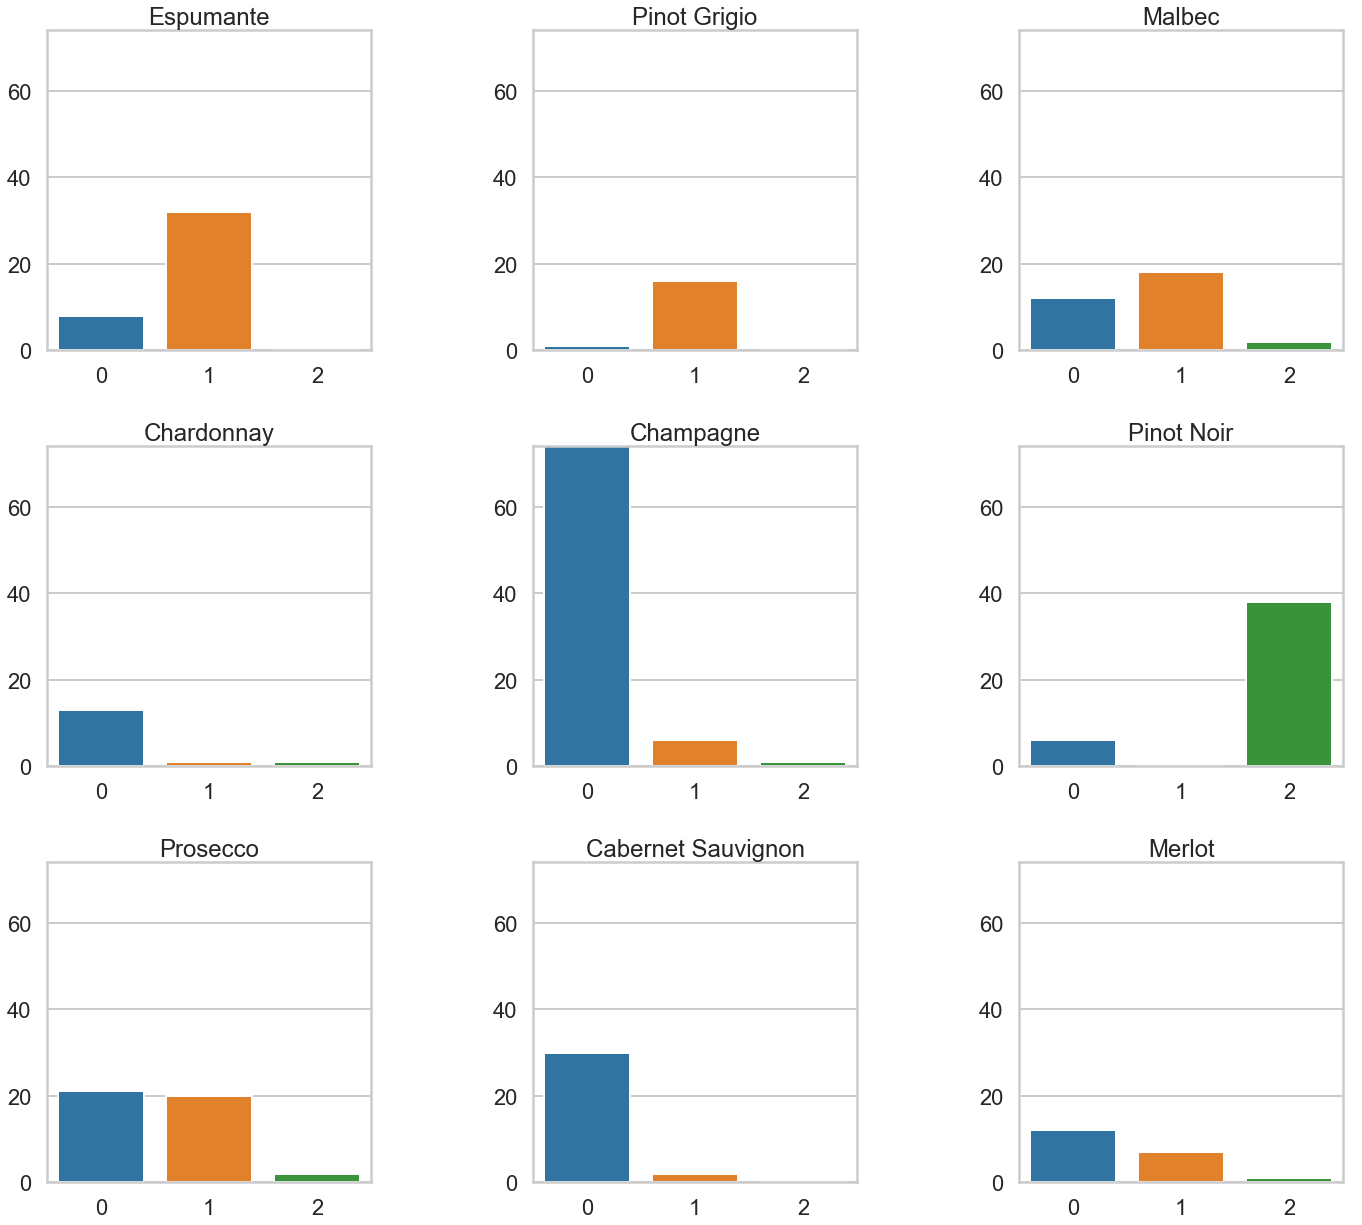

In [23]:
# Variable
variable = 'varietal'

# labels
clusters = np.arange(K)

# options
options = raw_clust[variable].unique()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(3, 3, i+1)
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title(options[i])

plt.subplots_adjust(left=0, bottom=-3, right=3, top=1, wspace=0.5, hspace=0.3)
plt.show()

min_qty

In [24]:
raw_clust.min_qty.unique()

array([  6, 144,  72,  12], dtype=int64)

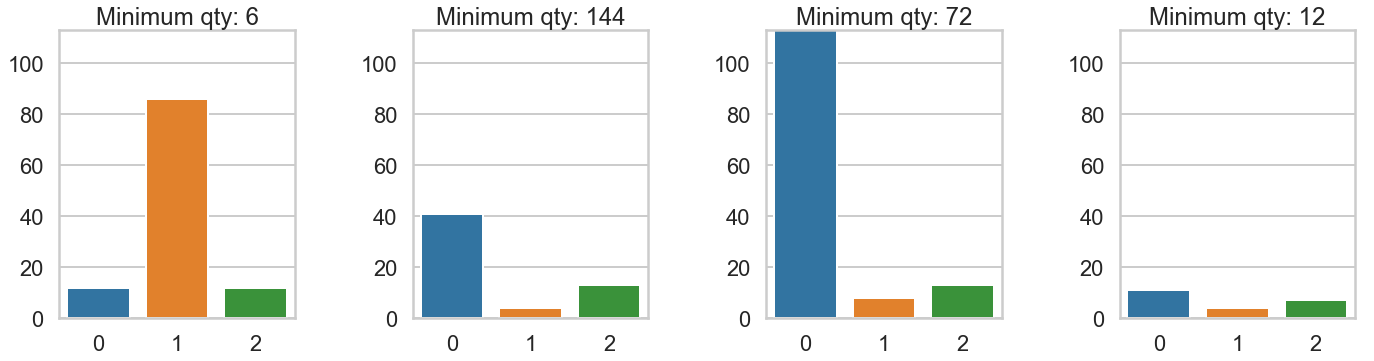

In [25]:
# Variable
variable = 'min_qty'

# labels
clusters = np.arange(K)

# options
options = raw_clust[variable].unique()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(1, 4, i+1) 
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title("Minimum qty: {}".format(options[i]))

plt.subplots_adjust(left=0, bottom=0, right=3, top=1, wspace=0.5, hspace=0.3)
plt.show()

discount

In [26]:
raw_clust.discount.sort_values().unique()

array([17, 19, 32, 34, 39, 40, 43, 44, 45, 47, 48, 50, 52, 54, 56, 57, 59,
       63, 64, 66, 82, 83, 85, 86, 87, 88, 89], dtype=int64)

Number of different discounts: 27
Low:  [17 19 32 34 39 40 43 44 45]
Medium:  [47 48 50 52 54 56 57 59 63]
High:  [64 66 82 83 85 86 87 88 89]


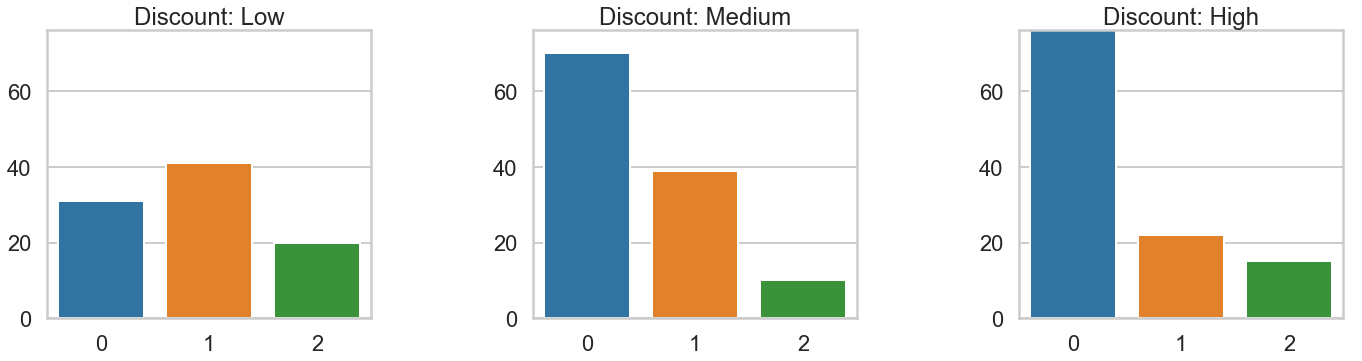

In [27]:
# Variable
variable = 'discount'

# subdivide into 3 intervals with 9 values each: low, medium, high
discounts = raw_clust.discount.sort_values().unique()

print("Number of different discounts:", len(discounts)) 

low = discounts[:9]
medium = discounts[9:18]
high = discounts[18:]

print("Low: ", low)
print("Medium: ", medium)
print("High: ", high)

# labels
clusters = np.arange(K)

# options
options = discounts.copy()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

new_matrix = np.array([[np.sum(matrix[0][:9]), np.sum(matrix[0][9:18]), np.sum(matrix[0][18:])], 
                       [np.sum(matrix[1][:9]), np.sum(matrix[1][9:18]), np.sum(matrix[1][18:])], 
                       [np.sum(matrix[2][:9]), np.sum(matrix[2][9:18]), np.sum(matrix[2][18:])]])

# plot
titles = ["Low", "Medium", "High"]

for i in range(len(new_matrix)):
    plt.subplot(1, 3, i+1) 
    sizes = new_matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(new_matrix))
    plt.title("Discount: {}".format(titles[i]))

plt.subplots_adjust(left=0, bottom=0, right=3, top=1, wspace=0.5, hspace=0.3)
plt.show()

origin

In [28]:
raw_clust.origin.unique()

array(['Oregon', 'France', 'Chile', 'New Zealand', 'Italy', 'Australia',
       'California', 'Germany', 'South Africa'], dtype=object)

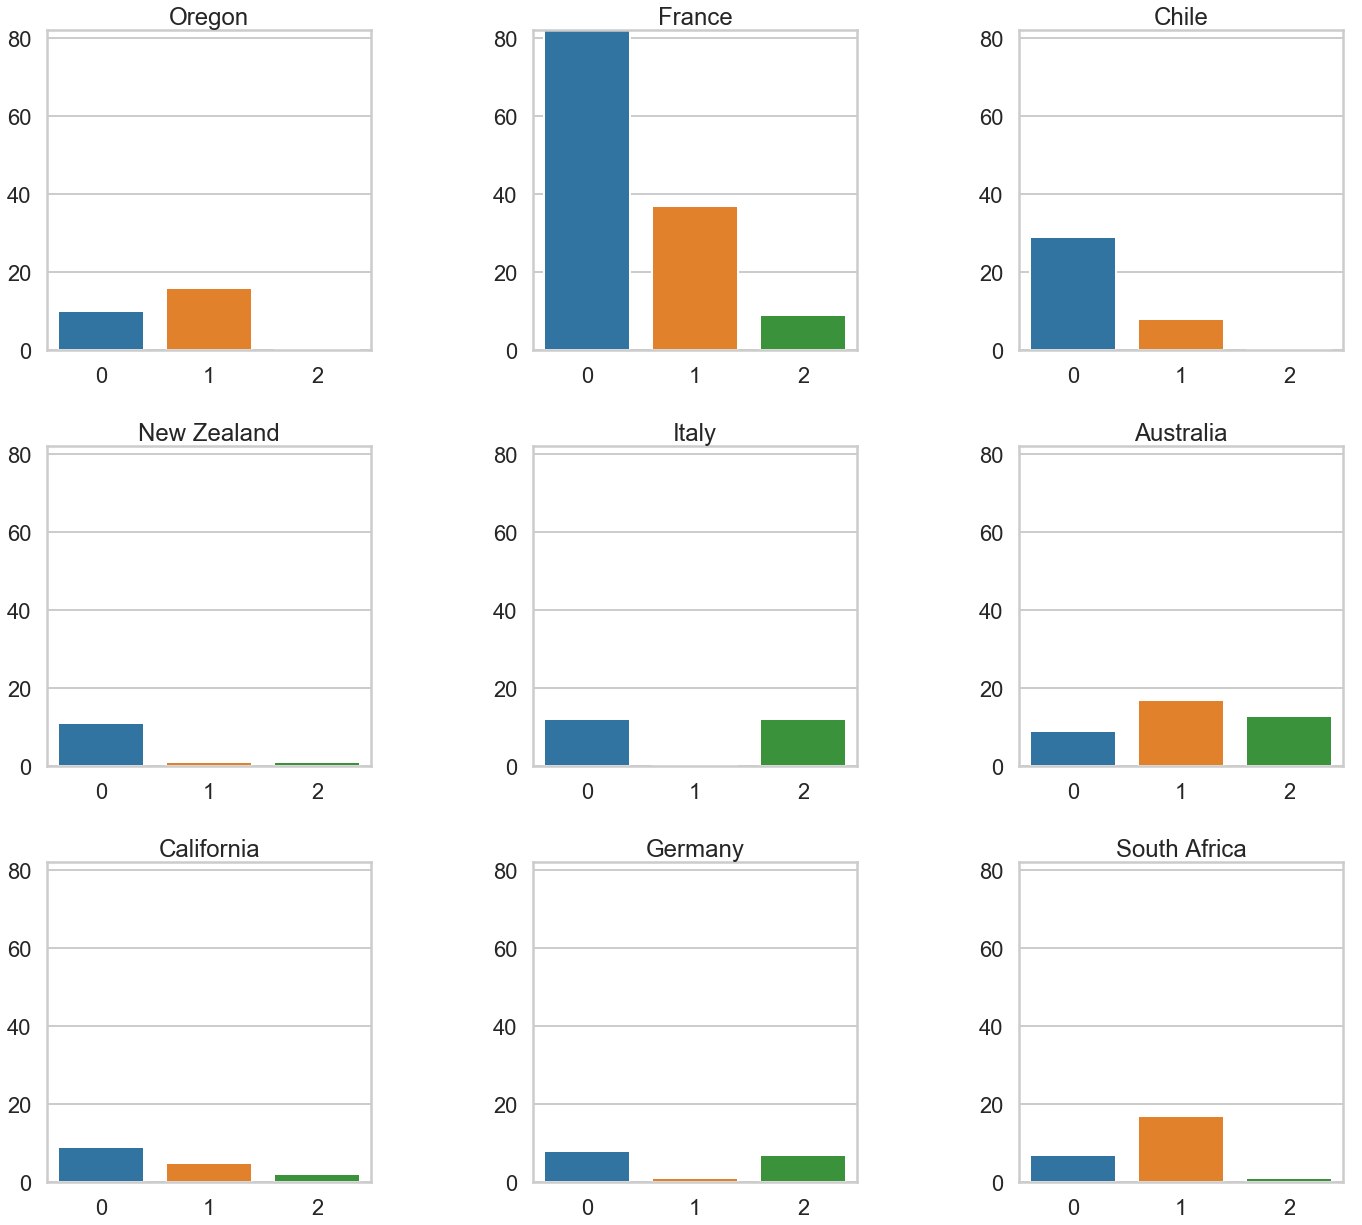

In [29]:
# Variable
variable = 'origin'

# labels
clusters = np.arange(K)

# options
options = raw_clust[variable].unique()

sizes = []

for j in clusters:
    for i in options:
        if i in raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size():
            sizes.append(raw_clust[raw_clust['cluster_id'] == j].groupby(variable).size().loc[i])
        else:
            sizes.append(0)

shape = (K, len(options))
matrix = np.array(sizes).reshape(shape)

# plot
for i in range(len(options)):
    plt.subplot(3, 3, i+1)
    sizes = matrix[:, i]
    sns.barplot(x=clusters, y=sizes, hue=clusters, dodge=False).get_legend().remove()
    plt.ylim(0, np.max(matrix))
    plt.title(options[i])

plt.subplots_adjust(left=0, bottom=-3, right=3, top=1, wspace=0.5, hspace=0.3)
plt.show()

**Cluster 0:**

* The cluster with the highest number of individual clients (more than 40). They seem to buy more or less equally around the year, with no particular month in highlight. They have a very high preference for Champagne, but they also aim 'Cabernet Sauvignon' and 'Prosecco' discounts (about 1/3 of the Champagne amount and 1/5, respectively). Hence french wines are highlighted. They target medium and high discounts, which is not surprising since Champagne discounts belong to that range. The situation is a bit different with 'Cabernet Sauvignon' though: they go for it even with low discounts.   

In [30]:
# Total Champagne discounts
print("Champagne discounts:", raw_clust[raw_clust['varietal'] == 'Champagne'].shape[0])

# Champagne low discounts
print("Champagne low discounts:", 
      raw_clust[(raw_clust['varietal'] == 'Champagne') & (raw_clust['discount'].isin(low))].shape[0])

# Total 'Cabernet Sauvignon' discounts
print("'Cabernet Sauvignon' discounts:", raw_clust[raw_clust['varietal'] == 'Cabernet Sauvignon'].shape[0])

# 'Cabernet Sauvignon' low discounts
print("'Cabernet Sauvignon' low discounts (cluster_id == 0):", 
      raw_clust[(raw_clust['varietal'] == 'Cabernet Sauvignon') & (raw_clust['discount'].isin(low)) & 
                (raw_clust['cluster_id'] == 0)].shape[0])

Champagne discounts: 81
Champagne low discounts: 0
'Cabernet Sauvignon' discounts: 32
'Cabernet Sauvignon' low discounts (cluster_id == 0): 14


**Cluster 1:**

* The second largest cluster, with around 35 individuals. March is a good month for them to buy, and in a lesser extent July, November and December. 'Espumante' is their favorite, but 'Pinot Grigio', 'Malbec' and 'Prosecco' are also strong candidates for this cluster. There exists a strong correlation between these two last variables. They aim for low and medium discounts, and almost only go for 'Pinot Grigio' in high discounts (only one has not high discount).

In [31]:
# Cluster 1: correlation between months and varieties
print(raw_clust[(raw_clust['varietal'].isin(['Espumante', 'Pinot Grigio', 'Malbec', 'Prosecco'])) & 
         (raw_clust['cluster_id'] == 1)].campaign.value_counts(), "\n")

# Cluster 1: correlation between varieties and discount
print("High discounts:\n", raw_clust[(raw_clust['discount'].isin(high)) & (raw_clust['cluster_id'] == 1)].varietal
      .value_counts())

# Total 'Pinot Grigio' discounts
print("'Pinot Grigio' total discounts:", raw_clust[raw_clust['varietal'] == 'Pinot Grigio'].shape[0], "\n")

# Cluster 1: correlation between varieties and discount
print("Low discounts:\n", raw_clust[(raw_clust['discount'].isin(low)) & (raw_clust['cluster_id'] == 1)].varietal
      .value_counts())


March       34
December    18
November    16
July        13
April        2
February     2
May          1
Name: campaign, dtype: int64 

High discounts:
 Pinot Grigio    16
Champagne        3
Prosecco         2
Merlot           1
Name: varietal, dtype: int64
'Pinot Grigio' total discounts: 17 

Low discounts:
 Espumante    19
Prosecco     16
Merlot        6
Name: varietal, dtype: int64


**Cluster 2:**

* Cluster 2 is the smallest cluster with around 15 individuals. They are characterized by aiming almost exclusively for 'Pinot Noir', particularly of Australian and Italian origin, but also German and French.

In [32]:
# 'Pinot Noir' and its origin (Cluster 2)
raw_clust[(raw_clust['varietal'].isin(['Pinot Noir'])) & (raw_clust['cluster_id'] == 2)].origin.value_counts()

Australia    12
Italy        12
France        7
Germany       7
Name: origin, dtype: int64

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

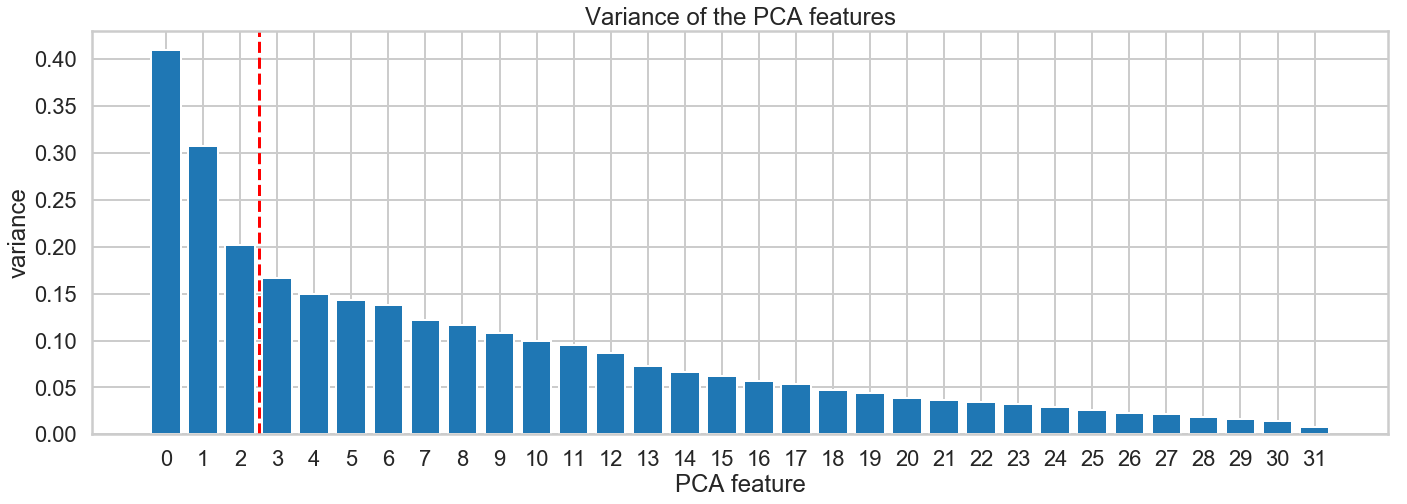

In [33]:
#your turn
X = x_cols.copy()

# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_)

# formatting
plt.title("Variance of the PCA features")
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.axvline(x=2.5, c='red', linestyle='--')

plt.subplots_adjust(left=0, bottom=-0.4, right=3, top=1, wspace=0, hspace=0)
plt.show()

3 serves also well as an optimal number of dimensions.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [34]:
# Your turn

I will evaluate the algorithms using the average Silhouette score. For **KMeans**:

In [35]:
from sklearn.metrics import silhouette_score

# KMeans
number_of_clusters = np.arange(2, 11)

print("KMeans:")

clusters = []
scores = []

for i in number_of_clusters:
    model = KMeans(n_clusters=i, random_state=10)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For n_clusters={}, the average silhouette_score is {}".format(i, silhouette_scr))
    clusters.append(i)
    scores.append(silhouette_scr)

print("\n Best silhouette score: {} \n Number of clusters: {}".format(np.max(scores), clusters[np.argmax(scores)]))

KMeans:
For n_clusters=2, the average silhouette_score is 0.09365573283492713
For n_clusters=3, the average silhouette_score is 0.11889942863638556
For n_clusters=4, the average silhouette_score is 0.12347053919571699
For n_clusters=5, the average silhouette_score is 0.14092516241984757
For n_clusters=6, the average silhouette_score is 0.1371798939109807
For n_clusters=7, the average silhouette_score is 0.1161092456616906
For n_clusters=8, the average silhouette_score is 0.11339573832632867
For n_clusters=9, the average silhouette_score is 0.12505960527779877
For n_clusters=10, the average silhouette_score is 0.11928332134753233

 Best silhouette score: 0.14092516241984757 
 Number of clusters: 5


**1. Affinity propagation**

In [36]:
from sklearn.cluster import AffinityPropagation

print("AffinityPropagation:")

dampings = np.arange(0.5, 1, 0.1)

damps = []
scores = []

for i in dampings:
    model = AffinityPropagation(damping=i)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For damping={}, the average silhouette_score is {}".format(i, silhouette_scr))
    damps.append(i)
    scores.append(silhouette_scr)
    
print("\n Best silhouette score: {} \n Damping: {}".format(np.max(scores), damps[np.argmax(scores)]))

AffinityPropagation:
For damping=0.5, the average silhouette_score is 0.12346523604478911
For damping=0.6, the average silhouette_score is 0.12346523604478911
For damping=0.7, the average silhouette_score is 0.12346523604478911
For damping=0.7999999999999999, the average silhouette_score is 0.08954554999885996
For damping=0.8999999999999999, the average silhouette_score is 0.08954554999885996

 Best silhouette score: 0.12346523604478911 
 Damping: 0.5


**2. Spectral clustering**

In [37]:
from sklearn.cluster import SpectralClustering

print("SpectralClustering:")

number_of_clusters = np.arange(2, 11)

clusters = []
scores = []

for i in number_of_clusters:
    model = SpectralClustering(n_clusters=i, random_state=10)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For n_clusters={}, the average silhouette_score is {}".format(i, silhouette_scr))
    clusters.append(i)
    scores.append(silhouette_scr)

print("\n Best silhouette score: {} \n Number of clusters: {}".format(np.max(scores), clusters[np.argmax(scores)]))


SpectralClustering:
For n_clusters=2, the average silhouette_score is 0.07631909829627558
For n_clusters=3, the average silhouette_score is 0.10611539040197304
For n_clusters=4, the average silhouette_score is 0.08627893400734331
For n_clusters=5, the average silhouette_score is 0.09915711813463922
For n_clusters=6, the average silhouette_score is 0.09847779745663406
For n_clusters=7, the average silhouette_score is 0.08299798621366726
For n_clusters=8, the average silhouette_score is 0.10795290206617342
For n_clusters=9, the average silhouette_score is 0.09119269817131899
For n_clusters=10, the average silhouette_score is 0.08294476827044912

 Best silhouette score: 0.10795290206617342 
 Number of clusters: 8


**3. Agglomerative clustering**

In [38]:
from sklearn.cluster import AgglomerativeClustering

linkage = 'ward'

print("AgglomerativeClustering (linkage={}):".format(linkage))

number_of_clusters = np.arange(2, 11)

clusters = []
scores = []

for i in number_of_clusters:
    model = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For n_clusters={}, the average silhouette_score is {}".format(i, silhouette_scr))
    clusters.append(i)
    scores.append(silhouette_scr)

print("\n Best silhouette score: {} \n Number of clusters: {}".format(np.max(scores), clusters[np.argmax(scores)]))


AgglomerativeClustering (linkage=ward):
For n_clusters=2, the average silhouette_score is 0.08258017823184984
For n_clusters=3, the average silhouette_score is 0.11625878863607858
For n_clusters=4, the average silhouette_score is 0.128937578158815
For n_clusters=5, the average silhouette_score is 0.14089739970831974
For n_clusters=6, the average silhouette_score is 0.1471521720461323
For n_clusters=7, the average silhouette_score is 0.15275152751051155
For n_clusters=8, the average silhouette_score is 0.15578053718604024
For n_clusters=9, the average silhouette_score is 0.12075124131971901
For n_clusters=10, the average silhouette_score is 0.09754750747147792

 Best silhouette score: 0.15578053718604024 
 Number of clusters: 8


In [39]:
linkage = 'complete'

print("AgglomerativeClustering (linkage={}):".format(linkage))

number_of_clusters = np.arange(2, 11)

clusters = []
scores = []

for i in number_of_clusters:
    model = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For n_clusters={}, the average silhouette_score is {}".format(i, silhouette_scr))
    clusters.append(i)
    scores.append(silhouette_scr)

print("\n Best silhouette score: {} \n Number of clusters: {}".format(np.max(scores), clusters[np.argmax(scores)]))


AgglomerativeClustering (linkage=complete):
For n_clusters=2, the average silhouette_score is 0.2348896595208253
For n_clusters=3, the average silhouette_score is 0.0564209072156317
For n_clusters=4, the average silhouette_score is 0.04965592388360875
For n_clusters=5, the average silhouette_score is 0.08118536531581164
For n_clusters=6, the average silhouette_score is 0.09326599371031147
For n_clusters=7, the average silhouette_score is 0.11408332240584
For n_clusters=8, the average silhouette_score is 0.1113991600144103
For n_clusters=9, the average silhouette_score is 0.11363460500092837
For n_clusters=10, the average silhouette_score is 0.11955909579643043

 Best silhouette score: 0.2348896595208253 
 Number of clusters: 2


In [40]:
linkage = 'average'

print("AgglomerativeClustering (linkage={}):".format(linkage))

number_of_clusters = np.arange(2, 11)

clusters = []
scores = []

for i in number_of_clusters:
    model = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For n_clusters={}, the average silhouette_score is {}".format(i, silhouette_scr))
    clusters.append(i)
    scores.append(silhouette_scr)

print("\n Best silhouette score: {} \n Number of clusters: {}".format(np.max(scores), clusters[np.argmax(scores)]))


AgglomerativeClustering (linkage=average):
For n_clusters=2, the average silhouette_score is 0.2135580573835938
For n_clusters=3, the average silhouette_score is 0.18987407904100467
For n_clusters=4, the average silhouette_score is 0.16084385829113018
For n_clusters=5, the average silhouette_score is 0.15439411463251862
For n_clusters=6, the average silhouette_score is 0.1301221448619551
For n_clusters=7, the average silhouette_score is 0.11946952796802679
For n_clusters=8, the average silhouette_score is 0.10527622039144402
For n_clusters=9, the average silhouette_score is 0.10247648723455666
For n_clusters=10, the average silhouette_score is 0.10909283264419782

 Best silhouette score: 0.2135580573835938 
 Number of clusters: 2


In [41]:
linkage = 'single'

print("AgglomerativeClustering (linkage={}):".format(linkage))

number_of_clusters = np.arange(2, 11)

clusters = []
scores = []

for i in number_of_clusters:
    model = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For n_clusters={}, the average silhouette_score is {}".format(i, silhouette_scr))
    clusters.append(i)
    scores.append(silhouette_scr)

print("\n Best silhouette score: {} \n Number of clusters: {}".format(np.max(scores), clusters[np.argmax(scores)]))


AgglomerativeClustering (linkage=single):
For n_clusters=2, the average silhouette_score is 0.27922277291704123
For n_clusters=3, the average silhouette_score is 0.17074349041382006
For n_clusters=4, the average silhouette_score is 0.16468837239678863
For n_clusters=5, the average silhouette_score is 0.13953487057202724
For n_clusters=6, the average silhouette_score is 0.09635420664117529
For n_clusters=7, the average silhouette_score is 0.0893179684821581
For n_clusters=8, the average silhouette_score is 0.06089881940200856
For n_clusters=9, the average silhouette_score is 0.059364680169401496
For n_clusters=10, the average silhouette_score is 0.06035277947694371

 Best silhouette score: 0.27922277291704123 
 Number of clusters: 2


**4. DBSCAN**

In [42]:
from sklearn.cluster import DBSCAN

print("DBSCAN:")

min_samples = np.arange(1, 3)

samples = []
scores = []

for i in min_samples:
    model = DBSCAN(eps=i)
    labels = model.fit_predict(x_cols)
    silhouette_scr = silhouette_score(x_cols, labels)
    print("For min_samples={}, the average silhouette_score is {}".format(i, silhouette_scr))
    samples.append(i)
    scores.append(silhouette_scr)

print("\n Best silhouette score: {} \n Samples: {}".format(np.max(scores), clusters[np.argmax(scores)]))


DBSCAN:
For min_samples=1, the average silhouette_score is 0.012715203274911742
For min_samples=2, the average silhouette_score is 0.2348896595208253

 Best silhouette score: 0.2348896595208253 
 Samples: 3


Silhouette score:

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

The algorithm that performs the best is the Agglomerative clustering, considering the 'single' linkage method, that is, a minimal intercluster dissimilarity - computes all pairwise dissimilarities between the clusters observations and record the smallest of these - with a silhouette score equal to 0.279 and 2 clusters. The score is far from perfect, with a "weak structure and possibly artificial", as the given source above classifies. The problem seems hard nonetheless since none of the methods got a good score. The Agglomerative clustering algorithm seems to perform better in general in this context too, and it scored higher when decreasing the number of clusters, which turned out to be right as seen when decomposing the data to 2 dimensions. So, overall, this points to the consideration of 2 or 3 clusters.